# lab5

## 数据预处理

In [1]:
!pip install wandb
!pip install transformers
!pip install pytorch_lightning
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 57.3 MB/s 
     |████████████████████████████████| 145 kB 65.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a637ad7fcfae4120b02a08534cc65bbd0d5d820d3dff221ae28939be80d05783
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 8.3 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 6.6 MB 13.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing in

In [2]:
import torch
import pandas as pd
from os.path import join
from PIL import Image
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from nltk.corpus import stopwords
import nltk
import os
import re
import torchvision
import sys
import cv2 as cv
nltk.download('stopwords')
en_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
en_stops.add("")
en_stops.add(" ")

### utils

In [ ]:
def getfilelist(rlist,path,type):
    for dir,folder,file in os.walk(path):
        for i in file:
          suffix = i.split(".")[1]
          if(suffix == type):
            t = "%s/%s"%(dir,i)
            rlist.append(t)
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def show_model_structure(model):
  params = list(model.named_parameters())
  print('==== Embedding Layer ====\n')

  for p in params[:]:
      print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size())))) 

In [ ]:
|# 图像处理为1200x1200的图片
def test(path,i):
    src = cv.imread(path) 
    top = (1200-src.shape[0])//2 # shape[0] = rows
    bottom = 1200-src.shape[0]-top
    left = (1200-src.shape[1])//2 # shape[1] = cols
    right = 1200-src.shape[1]-left
#     print(src.shape[1])
    value = [255,255,255]
    
    borderType = cv.BORDER_CONSTANT
    dst1 = cv.copyMakeBorder(src, top, bottom, left, right, borderType, None, value)
    cv.imwrite(str(i), dst1);

SyntaxError: ignored

### txt 处理-> csv

In [ ]:
txt_path_list = []
getfilelist(txt_path_list,"./content/drive/MyDrive/lab5_data/data","txt")
len(txt_path_list)

4870

In [ ]:
txt_list = []
for i in range(len(txt_path_list)) :
  file1=open(txt_path_list[i],'r', encoding= 'utf-8',errors='ignore')
  content1=file1.read()
  txt_list.append(content1)
  file1.close()     


In [ ]:
file_number = []
for i in range(len(txt_path_list)):
  filenumber = txt_path_list[i].split('/')[-1].split('.')[0]
  file_number.append(filenumber)

#### 设立token

In [ ]:
all_words = []
txt_split = []
def delete_boring_characters(sentence):
    return re.sub('[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+', "", sentence)

def delete_http_characters(sentence):
    return re.sub('[h][t][t][p][a-zA-Z]{0,}', "", sentence)


for i in range(len(txt_list)):
  new_string =  delete_boring_characters(txt_list[i])
  txt_list[i] = new_string
  new_string = delete_http_characters(new_string).lower()
  new_string = new_string.strip('\n')
  words = new_string.split(' ') 
  new_txt = []
  for word in words:
    if word not in en_stops:
        new_txt.append(word)
        all_words.append(word)
  txt_split.append(new_txt)
  new_string = new_string.split(' ')
  for j in range(len(new_string)):
    all_words.append(new_string[j])

all_words = set(all_words)

In [ ]:
my_dict = dict()
token_id = 1
for word in all_words:
  if word not in my_dict:
    my_dict[word]=token_id
    token_id+=1
def get_token_ids(txt):
  res = torch.zeros(len(txt))
  for i, word in enumerate(txt):
      res[i-1] = my_dict[word]
  return res

In [ ]:
txt_token = []
for i in range(len(txt_list)):
  txt_token.append(get_token_ids(txt_split[i]))

In [ ]:
txt_df = pd.DataFrame({'file_number':file_number, 'text_content':txt_list,"txt_split":txt_split,"text_token":txt_token})

In [ ]:
txt_df.head(2)

file_number                                       text_content  \
0        5004  PPSellsBabyParts for a large profit so their e...   
1        5009  RT ALLCAPSMARVEL overjoyed  bastille httptcoSp...   

                                           txt_split  \
0  [ppsellsbabyparts, large, profit, employees, l...   
1           [rt, allcapsmarvel, overjoyed, bastille]   

                                          text_token  
0  [tensor(594.), tensor(8257.), tensor(9051.), t...  
1  [tensor(12741.), tensor(6667.), tensor(9103.),...

### 图像处理

In [ ]:
!pip install opencv-contrib-python
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imutils import paths
import numpy as np
import shutil

In [ ]:
img_list = []
getfilelist(img_list,"./content/drive/MyDrive/lab5_data/data2","jpg")
len(img_list)

4869

#### 把图片resize成1200x1200

只用做一次

In [ ]:
img_file_number = []
for i in range(len(img_list)):
  filenumber = img_list[i].split('/')[-1].split('.')[0]
  img_file_number.append(filenumber)

In [ ]:
rows = []
for i in range(len(img_list)):
    src = cv.imread(img_list[i]) 
    rows.append(src.shape[0])
rows.sort() # 行宽最大1200


In [ ]:
cols = []
for i in range(len(img_list)):
    src = cv.imread(img_list[i]) 
    cols.append(src.shape[1])
cols.sort() # 列高最大600

In [ ]:
# 都变成 1200x1200的图像
for i in range(len(img_list)):
    test(img_list[i],img_list[i]);

In [ ]:
img_df = pd.DataFrame({'file_number':img_file_number, 'img_path':img_list})

#### 图片预分类

+ 读入 img_path和emotion 的数据表(之前已经做好)
+ 把图片分成训练集和测试集两个部分，并把图片分到对应的文件夹当中(如 /train/negative/xxx.jpg)

In [ ]:
img_tags_df = pd.read_csv("./content/drive/MyDrive/lab5_data/img_with_tags2")
img_tags_df.head(2)

Unnamed: 0  file_number                                         img_path  \
0           0           77    /content/drive/MyDrive/lab5_data/data2/77.jpg   
1           1         3544  /content/drive/MyDrive/lab5_data/data2/3544.jpg   

    emotion  labels  
0  positive     1.0  
1  negative     0.0

In [ ]:
train_img = img_tags_df[img_tags_df["emotion"].notnull()]
test_img = img_tags_df[img_tags_df["emotion"].isnull()]
train_img = train_img.drop(labels=["Unnamed: 0"],axis=1)
test_img =test_img.drop(labels=["Unnamed: 0"],axis=1)
train_img.labels = train_img.labels.astype(int)

In [ ]:
ls

data/  img_with_tags  test_without_label.txt  train.txt  txt_with_tags


In [ ]:
train_img.head(2)

file_number                                         img_path   emotion  \
0           77    /content/drive/MyDrive/lab5_data/data2/77.jpg  positive   
1         3544  /content/drive/MyDrive/lab5_data/data2/3544.jpg  negative   

   labels  
0       1  
1       0

In [ ]:
DATASET_PATH = "./content/drive/MyDrive/lab5_data/data/"
# specify the paths to our training and validation set 
TRAIN = "./content/drive/MyDrive/lab5_data/train2"
VAL = "./content/drive/MyDrive/lab5_data/val2"

# set the batch size and validation data split
BATCH_SIZE = 16
VAL_SPLIT = 0.1

In [ ]:
def copy_images(imagePath, folder, label):
  if not os.path.exists(folder):
    os.makedirs(folder)
  imageName = imagePath.split(os.path.sep)[-1]
  labelFolder = os.path.join(folder, label)
  if not os.path.exists(labelFolder):
    os.makedirs(labelFolder)
  destination = os.path.join(labelFolder, imageName)
  shutil.copy(imagePath, destination)

In [ ]:
img_path_and_tags = train_img[["img_path","emotion"]]
img_path_and_tags_list = img_path_and_tags.values.tolist()

In [ ]:
# load all the image paths and randomly shuffle them
np.random.shuffle(img_path_and_tags_list)
# generate training and validation paths
valPathsLen = int(len(img_path_and_tags_list) * VAL_SPLIT)
trainPathsLen = len(img_path_and_tags_list) - valPathsLen
trainPaths = img_path_and_tags_list[:trainPathsLen]
valPaths = img_path_and_tags_list[trainPathsLen:]



In [ ]:
len(trainPaths)

3600

In [ ]:
for i in range(len(trainPaths)):
  copy_images(trainPaths[i][0],TRAIN,trainPaths[i][1])

In [ ]:
for i in range(len(valPaths)):
  copy_images(valPaths[i][0],VAL,valPaths[i][1])

### 添加标签

In [ ]:
tagfile = "./content/drive/MyDrive/lab5_data/train.txt"

In [ ]:
tags = []
file1=open(tagfile,'r', encoding= 'ISO-8859-15')
for line in file1:
  tags.append(line.strip('\n'))
file1.close()     
del(tags[0])


In [ ]:
label_dict = {"negative":0,"positive":1,"neutral":2}

labels = []
for i in range(len(tags)):
  tags[i] = tags[i].split(',')
  emotion = tags[i][1]
  labels.append(label_dict[emotion])


In [ ]:
len(labels)

4000

In [ ]:
tags_df = pd.DataFrame(tags,columns=["file_number","emotion"])
tags_df["labels"] =labels
tags_df.head()

file_number   emotion  labels
0        4597  negative       0
1          26   neutral       2
2        4383  negative       0
3         212  positive       1
4        2626  positive       1

In [ ]:
txt_tags_df = pd.merge(txt_df,tags_df,  how='left', on =['file_number'])
img_tags_df = pd.merge(img_df,tags_df,  how='left', on =['file_number'])


In [ ]:
img_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4869 entries, 0 to 4868
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_number  4869 non-null   object 
 1   img_path     4869 non-null   object 
 2   emotion      4000 non-null   object 
 3   labels       4000 non-null   float64
dtypes: float64(1), object(3)
memory usage: 190.2+ KB


In [ ]:
txt_tags_df.to_csv("./content/drive/MyDrive/lab5_data/txt_with_tags")
img_tags_df.to_csv("./content/drive/MyDrive/lab5_data/img_with_tags")

## 训练

### 训练文本

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer
import torch
import wandb
wandb.login()

wandb: Currently logged in as: jasonxu (ecnudase2019). Use `wandb login --relogin` to force relogin


True

#### 数据读取

In [ ]:
txt_tags_df = pd.read_csv("./content/drive/MyDrive/lab5_data/txt_with_tags")

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
train_txt = txt_tags_df[txt_tags_df["emotion"].notnull()]
test_txt = txt_tags_df[txt_tags_df["emotion"].isnull()]
train_txt = train_txt.drop(labels=["Unnamed: 0"],axis=1)
test_txt =test_txt.drop(labels=["Unnamed: 0"],axis=1)
train_txt.labels = train_txt.labels.astype(int)


In [ ]:
sentences = train_txt.text_content.values
labels = train_txt.labels.values

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  RT PackMensBball WANTED passionate Pack fans Send picsvideos from games to show your Pack passion Link  httptcoNGIcXRXwBR ht

Tokenized:  ['rt', 'pack', '##men', '##sb', '##ball', 'wanted', 'passionate', 'pack', 'fans', 'send', 'pic', '##s', '##vid', '##eo', '##s', 'from', 'games', 'to', 'show', 'your', 'pack', 'passion', 'link', 'http', '##tc', '##ong', '##ic', '##x', '##r', '##x', '##w', '##br', 'h', '##t']
Token IDs:  [19387, 5308, 3549, 19022, 7384, 2359, 13459, 5308, 4599, 4604, 27263, 2015, 17258, 8780, 2015, 2013, 2399, 2000, 2265, 2115, 5308, 6896, 4957, 8299, 13535, 5063, 2594, 2595, 2099, 2595, 2860, 19892, 1044, 2102]


In [ ]:
max_len = 0
# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    if(sent!=None):
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  49


In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,
                        padding= 64,           # Pad & truncate all sentences.
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

NameError: ignored

In [ ]:


# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,600 training samples
  400 validation samples


In [ ]:
dataset[1]

(tensor([  101, 19387,  5308,  3549, 19022,  7384,  2359, 13459,  5308,  4599,
          4604, 27263,  2015, 17258,  8780,  2015,  2013,  2399,  2000,  2265,
          2115,  5308,  6896,  4957,  8299, 13535,  5063,  2594,  2595,  2099,
          2595,  2860, 19892,  1044,  2102,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(1))

#### 模型建立

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import numpy as np
import random
import time
import datetime

In [ ]:
def ret_dataloader():
    batch_size = wandb.config.batch_size
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(train_dataset,
                                  sampler = RandomSampler(train_dataset), 
                                  batch_size = batch_size)

    validation_dataloader = DataLoader(val_dataset, 
                                       sampler = SequentialSampler(val_dataset),   
                                       batch_size = batch_size)
    return train_dataloader,validation_dataloader

def ret_model():
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", 
        num_labels = 3, 
        output_attentions = True, 
        output_hidden_states = True,
    )
    return model

def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate, 
                      eps = wandb.config.epsilon # args.adam_epsilon  - default is 1e-8.
                    )
    return optimizer

def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,           
num_training_steps = total_steps)
    return scheduler

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(reinit=True,project="multimodel_emotion_recognize",
           entity="ecnudase2019",
           config={"epochs":10,"batch_size":16,"learning_rate":  2e-6, "epsilon": 1e-7})

In [ ]:
model = ret_model()
# Tell pytorch to run this model on the GPU.
model.cuda()
train_dataloader,validation_dataloader = ret_dataloader()
optimizer = ret_optim(model)
scheduler = ret_scheduler(train_dataloader,optimizer)
training_stats = []
total_t0 = time.time()
epochs = wandb.config.epochs

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

batch_size =  16
Learning_rate =  2e-06


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt").to(device)
labels = torch.tensor([1]).unsqueeze(0).to(device)  # Batch size 1
outputs = model(**inputs, labels=labels)

In [ ]:
print(outputs.hidden_states[-1][0][0])
outputs.hidden_states[-1][0][0].size()

tensor([-1.1437e-01,  1.9371e-01,  1.2496e-01, -2.0383e-01, -1.4378e-01,
        -4.0133e-01,  3.7730e-02,  2.3569e-01, -6.0790e-02, -1.9952e-01,
         5.9023e-02,  3.7707e-02,  3.2113e-01,  4.2014e-01, -2.2282e-01,
        -5.3781e-04, -2.2813e-01,  5.3536e-01, -8.6111e-03,  1.0308e-01,
         3.2667e-02, -1.7121e-01, -1.5283e-01, -2.0048e-01,  8.0831e-02,
         6.3194e-02,  1.0636e-01,  2.7128e-01, -5.5215e-02,  1.3590e-01,
        -1.4784e-01,  8.4328e-02,  4.8230e-01,  5.4463e-02,  2.9880e-01,
        -1.0058e-01,  1.9039e-01,  1.6455e-02, -4.8770e-01,  5.6481e-02,
        -7.7710e-02,  5.1785e-03,  1.7279e-02, -1.6181e-01, -2.0358e-01,
        -2.5044e-01, -3.3015e+00, -5.0457e-02, -2.2364e-02, -5.3420e-01,
         3.7921e-01, -3.4782e-01, -2.6844e-01,  1.2522e-01,  2.2795e-01,
         2.1754e-01, -3.7036e-01,  7.2194e-02,  1.6204e-01,  4.0286e-02,
         2.2534e-01,  1.2130e-01, -1.2296e-02,  9.4006e-02, -1.4941e-01,
         1.0611e-01,  3.1475e-01,  2.9731e-01, -2.1

torch.Size([768])

In [ ]:
import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        # cls_hidden_state = hidden_states[-1] # the first hidden state in last layer

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        wandb.log({'train_batch_loss':output.loss.item()})
        total_train_loss += output.loss.item()
        # Perform a backward pass to calculate the gradients.
        output.loss.backward()
        quit()
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  
    avg_train_accuracy = total_train_accuracy / len(train_dataloader) 
    print("Train  Accuracy: {0:.2f}".format(avg_train_accuracy))

    wandb.log({'avg_train_loss':avg_train_loss,'avg_train_acc':avg_train_accuracy})
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += output.loss.item()

        # Move logits and labels to CPU
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids:  torch.Size([16, 64])
b_input_ids

NameError: ignored

### 训练图片

#### 模型建立

In [ ]:
from torchvision import datasets
from torchsummary import summary
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

In [ ]:
DATASET_PATH = "./content/drive/MyDrive/lab5_data/data/"
# specify the paths to our training and validation set 
TRAIN = "./content/drive/MyDrive/lab5_data/train2"
VAL = "./content/drive/MyDrive/lab5_data/val2"

# set the batch size and validation data split
BATCH_SIZE = 16
VAL_SPLIT = 0.1

In [ ]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE, BATCH_SIZE))
	# loop over the batch size
	for i in range(0, BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(4, 4, i + 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()

In [ ]:
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

trainTransforms = transforms.Compose([transforms.RandomResizedCrop(224),#随机裁剪为224x224的图片
                                      hFlip, 
                                      vFlip, 
                                      rotate,
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ],
                                     )
                                     
valTransforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [ ]:
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root=TRAIN,transform=trainTransforms)
valDataset = ImageFolder(root=VAL, transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(
        len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(
        len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 3600 samples...
[INFO] validation dataset contains 400 samples...


In [ ]:
trainDataset[1]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [ ]:
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, 
        batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)
dataset_sizes = {"train": len(trainDataset),"val":len(valDataset)}
dataloaders = {"train":trainDataLoader,"val":valDataLoader}

[INFO] creating training and validation set dataloaders...


[INFO] visualizing training and validation batch...


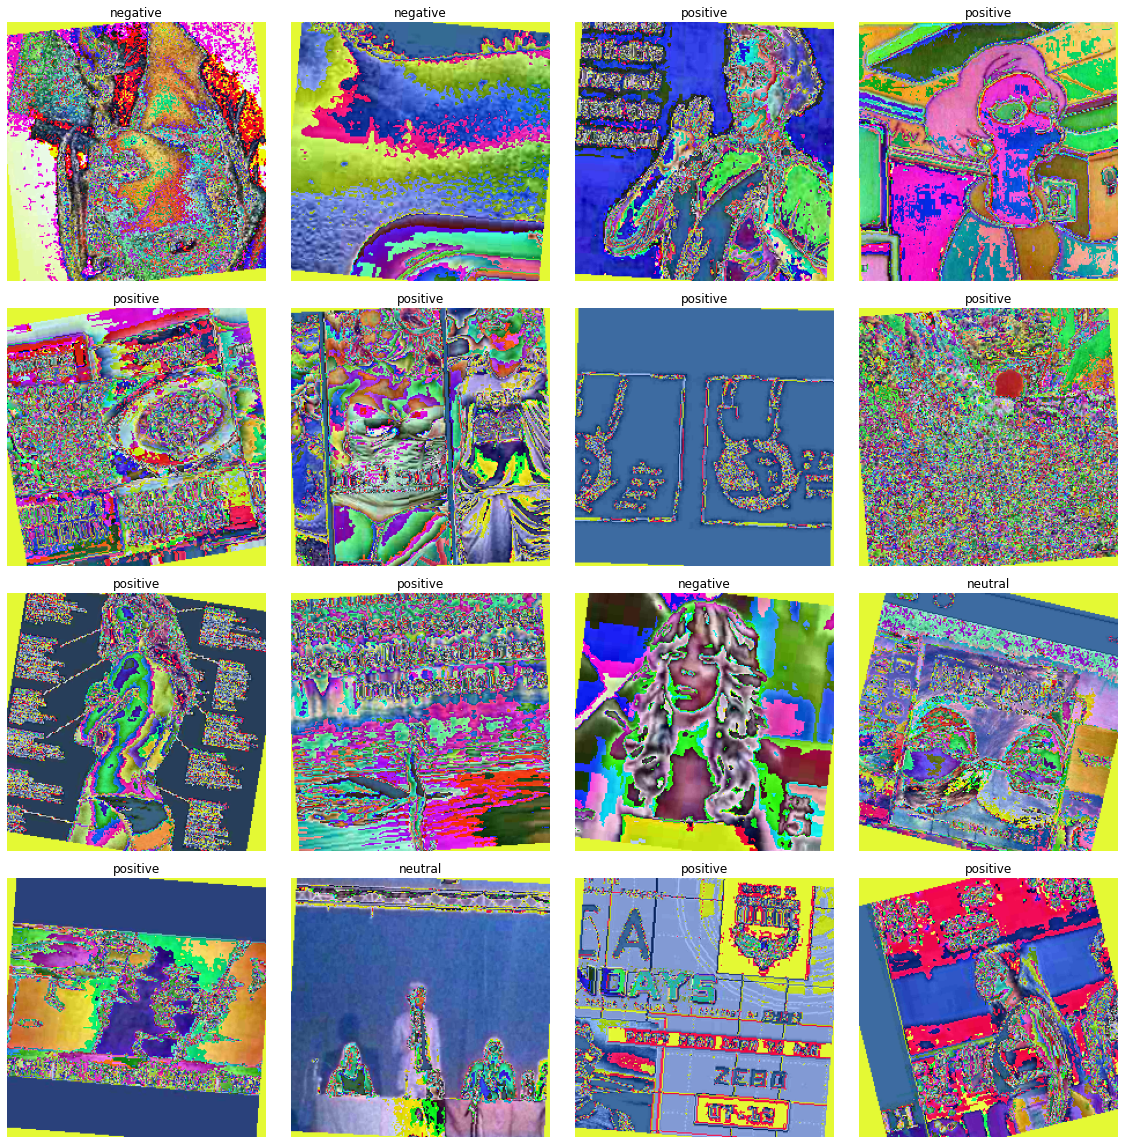

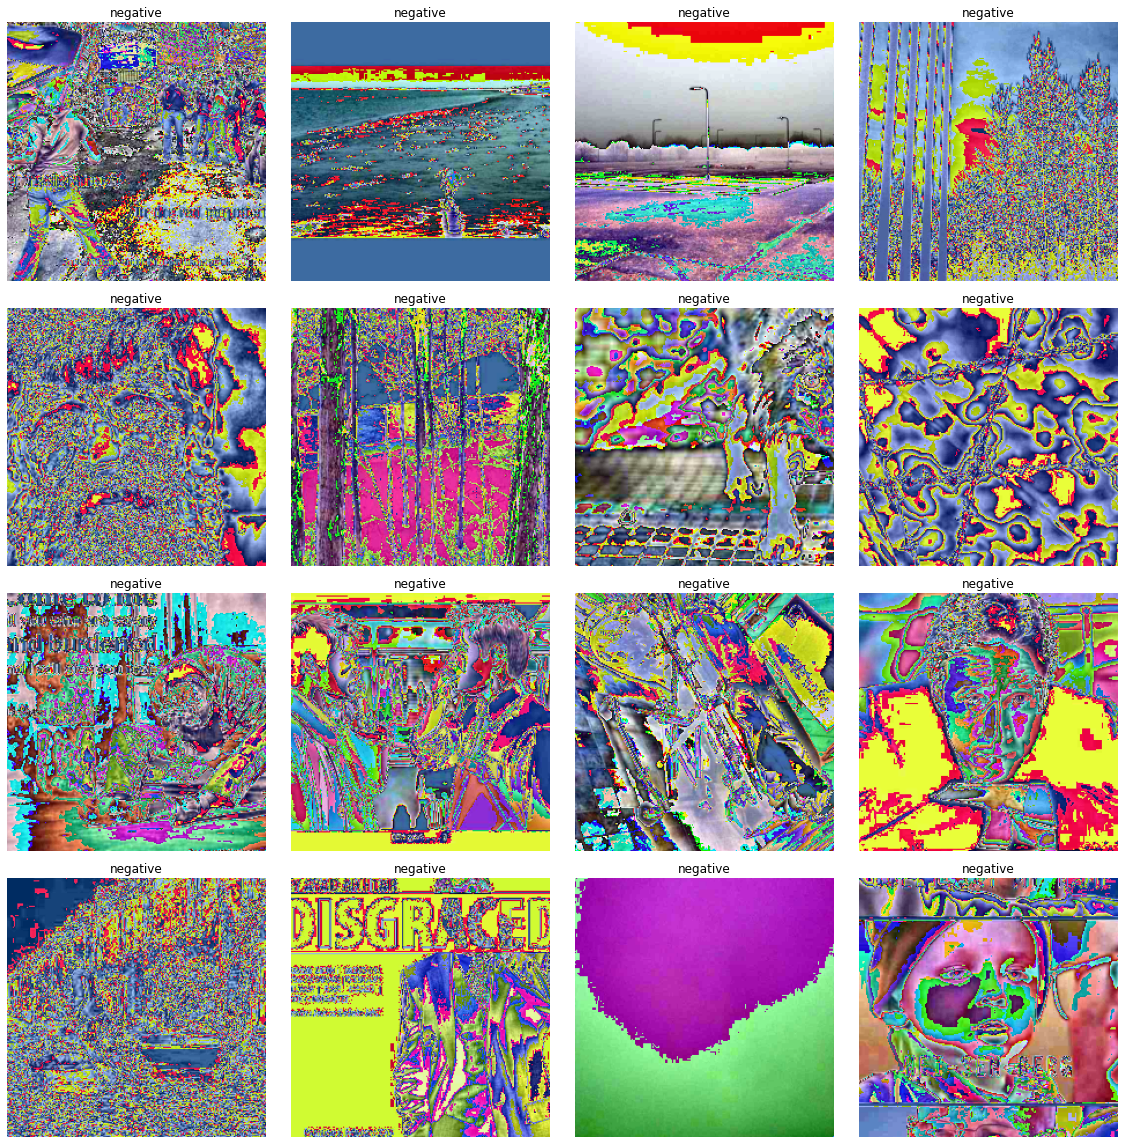

In [ ]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))
# visualize the training and validation set batches
print("[INFO] visualizing training and validation batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")
visualize_batch(valBatch, valDataset.classes, "val")

#### 训练

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [ ]:

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(wandb.config.epochs):
        print(f'Epoch {epoch+1}/{wandb.config.epochs}')
        print('-' * 10)
        t0 = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    wandb.log({"train_batch_loss":loss})
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            elapsed = format_time(time.time() - t0)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if(phase =='train'):
              print("  Training epcoh took: {:}".format(elapsed))
              wandb.log({'train_epoch_time':time.time() - t0})
              wandb.log({"train_avg_loss":epoch_loss,"train_avg_acc":epoch_acc})
            if(phase =='val'):
              wandb.log({"val_avg_loss":epoch_loss,"val_avg_acc":epoch_acc})
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
wandb.init(reinit=True,
           project="multimodel_emotion_recognize_only_img",
           config={"epochs":50,"batch_size":16,"model_type":"vgg"},
           entity="ecnudase2019")

##### ResNet18训练

In [ ]:
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_resnet.parameters(),lr = 1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
show_model_structure(model_resnet)

The BERT model has 62 different named parameters.

==== Embedding Layer ====

conv1.weight                                            (64, 3, 7, 7)
bn1.weight                                                     (64,)
bn1.bias                                                       (64,)
layer1.0.conv1.weight                                   (64, 64, 3, 3)
layer1.0.bn1.weight                                            (64,)
layer1.0.bn1.bias                                              (64,)
layer1.0.conv2.weight                                   (64, 64, 3, 3)
layer1.0.bn2.weight                                            (64,)
layer1.0.bn2.bias                                              (64,)
layer1.1.conv1.weight                                   (64, 64, 3, 3)
layer1.1.bn1.weight                                            (64,)
layer1.1.bn1.bias                                              (64,)
layer1.1.conv2.weight                                   (64, 64, 3, 3)
layer1.1.bn2.wei

In [ ]:
best_model_resnet = train_model(model_resnet, 
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler)

##### ResNet34训练

In [ ]:
model_resnet = models.resnet34(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 3)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_resnet.parameters(),lr = 1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
show_model_structure(model_resnet)

The BERT model has 110 different named parameters.

==== Embedding Layer ====

conv1.weight                                            (64, 3, 7, 7)
bn1.weight                                                     (64,)
bn1.bias                                                       (64,)
layer1.0.conv1.weight                                   (64, 64, 3, 3)
layer1.0.bn1.weight                                            (64,)
layer1.0.bn1.bias                                              (64,)
layer1.0.conv2.weight                                   (64, 64, 3, 3)
layer1.0.bn2.weight                                            (64,)
layer1.0.bn2.bias                                              (64,)
layer1.1.conv1.weight                                   (64, 64, 3, 3)
layer1.1.bn1.weight                                            (64,)
layer1.1.bn1.bias                                              (64,)
layer1.1.conv2.weight                                   (64, 64, 3, 3)
layer1.1.bn2.we

In [ ]:
best_model_resnet = train_model(model_resnet, 
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,)

##### VGG16训练

In [ ]:
model_vgg = models.vgg11(pretrained=True)
model_vgg.classifier[6]=nn.Linear(4096,3)

In [ ]:
show_model_structure(model_vgg)

The BERT model has 22 different named parameters.

==== Embedding Layer ====

features.0.weight                                       (64, 3, 3, 3)
features.0.bias                                                (64,)
features.3.weight                                       (128, 64, 3, 3)
features.3.bias                                               (128,)
features.6.weight                                       (256, 128, 3, 3)
features.6.bias                                               (256,)
features.8.weight                                       (256, 256, 3, 3)
features.8.bias                                               (256,)
features.11.weight                                      (512, 256, 3, 3)
features.11.bias                                              (512,)
features.13.weight                                      (512, 512, 3, 3)
features.13.bias                                              (512,)
features.16.weight                                      (512, 512, 3, 3)
f

In [ ]:
model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_vgg.parameters(),lr = 1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
best_model_vgg = train_model(model_vgg, 
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler)

Epoch 1/25
----------
train Loss: 0.8917 Acc: 0.5842
  Training epcoh took: 0:00:48
val Loss: 0.8934 Acc: 0.6075
Epoch 2/25
----------
train Loss: 0.8605 Acc: 0.6089
  Training epcoh took: 0:00:48
val Loss: 0.9225 Acc: 0.5975
Epoch 3/25
----------
train Loss: 0.8452 Acc: 0.6114
  Training epcoh took: 0:00:50
val Loss: 0.8819 Acc: 0.6250
Epoch 4/25
----------
train Loss: 0.8365 Acc: 0.6225
  Training epcoh took: 0:00:48
val Loss: 0.8636 Acc: 0.6250
Epoch 5/25
----------
train Loss: 0.8304 Acc: 0.6089
  Training epcoh took: 0:00:49
val Loss: 0.9743 Acc: 0.5900
Epoch 6/25
----------
train Loss: 0.7914 Acc: 0.6200
  Training epcoh took: 0:00:49
val Loss: 0.8572 Acc: 0.5850
Epoch 7/25
----------
train Loss: 0.7662 Acc: 0.6450
  Training epcoh took: 0:00:48
val Loss: 0.8716 Acc: 0.5925
Epoch 8/25
----------
train Loss: 0.7632 Acc: 0.6381
  Training epcoh took: 0:00:48
val Loss: 0.8547 Acc: 0.6150
Epoch 9/25
----------
train Loss: 0.7518 Acc: 0.6472
  Training epcoh took: 0:00:48
val Loss: 0.

### 融合

In [3]:
from PIL import Image
from pathlib import Path
from torchvision import datasets,transforms
from torchsummary import summary
from transformers import BertTokenizer
from torchvision.datasets import ImageFolder
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset, random_split
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.models as models
import torch
import wandb
import torchmetrics
import random
import torchvision
import numpy as np
import torch.nn as nn
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### 数据整合 

In [5]:
txt_tags_df = pd.read_csv("./content/drive/MyDrive/lab5_data/txt_with_tags")
img_tags_df = pd.read_csv("./content/drive/MyDrive/lab5_data/img_with_tags2")
# txt_tags_df.head(2)
not_null_txt_tags_df = txt_tags_df[(txt_tags_df["labels"].notnull())]
not_null_img_tags_df = img_tags_df[(img_tags_df["labels"].notnull())]
not_null_txt_tags_df.file_number = not_null_txt_tags_df.file_number.astype(int)
not_null_img_tags_df.labels = not_null_img_tags_df.labels.astype(int)

img_txt_tags_df = pd.merge(not_null_txt_tags_df,not_null_img_tags_df,  how='left', on =['file_number'])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
new_img_txt_tags_df = img_txt_tags_df[["file_number",'text_content','img_path','emotion_x','labels_x',]]
new_img_txt_tags_df.labels_x = new_img_txt_tags_df.labels_x.astype(int)
new_img_txt_tags_df. rename(columns = {'img_path':'img','emotion_x':'emotion', 'labels_x':'label'}, inplace = True)
new_img_txt_tags_df.to_csv("/content/drive/MyDrive/lab5_data/new_img_txt_tags_df.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
new_img_txt_tags_df = pd.read_csv("./content/drive/MyDrive/lab5_data/new_img_txt_tags_df.csv")
print(new_img_txt_tags_df.emotion.value_counts())
new_img_txt_tags_df.head(2)

positive    2388
negative    1193
neutral      419
Name: emotion, dtype: int64


Unnamed: 0  file_number                                       text_content  \
0           0         5004  PPSellsBabyParts for a large profit so their e...   
1           1         5033  RT PackMensBball WANTED passionate Pack fans S...   

                                               img   emotion  label  
0  /content/drive/MyDrive/lab5_data/data2/5004.jpg  negative      0  
1  /content/drive/MyDrive/lab5_data/data2/5033.jpg  positive      1

In [8]:
images = [
    Image.open(new_img_txt_tags_df.loc[i, "img"]).convert("RGB")
    for i in range(10,15)
]

for image in images:
    print(image.size)

(599, 399)
(48, 48)
(598, 145)
(599, 167)
(512, 288)


In [9]:
# define a callable image_transform with Compose
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

image_transform = transforms.Compose([transforms.RandomResizedCrop(224),#随机裁剪为224x224的图片
                                      hFlip, 
                                      vFlip, 
                                      rotate,
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ],
                                     )

In [10]:
class GetIMGandTXTDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        image_transform,
        tokenizer=None,
        random_state=0,
    ):
        self.samples_frame = new_img_txt_tags_df
        self.samples_frame = self.samples_frame.reset_index(drop=True)
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.samples_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "file_number"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")

        image = self.image_transform(image)

        encoded_dict = self.tokenizer.encode_plus(
                        self.samples_frame.loc[idx, "text_content"],    # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        padding= 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
        text = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        content = self.samples_frame.loc[idx, "text_content"]
        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "content":content,
                "attention_mask":attention_mask,
                "label": label,
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text,
                "content":content,
                "attention_mask":attention_mask,
            }

        return sample


In [11]:
total_train_dataset = GetIMGandTXTDataset (
            image_transform= image_transform,
            tokenizer=BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True),
      )

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
train_size = int(0.9 * len(total_train_dataset))
val_size = len(total_train_dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(total_train_dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,600 training samples
  400 validation samples


In [13]:
train_dataset[1]["label"]

tensor(1)

#### 模型创建

In [14]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        batch_size
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(int(language_feature_dim/batch_size) + vision_feature_dim) ,#flatten 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )

        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image,mask, label=None):
        text.resize_(16,64)
        text_output = self.language_module(
              input_ids=text, 
              attention_mask=mask, 
              labels=label)
        text_features = torch.nn.functional.relu(text_output.hidden_states[-1][0][0])
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )


        text_features = text_features.reshape(16,48)
        image_features = image_features.view(image_features.shape[0], -1)
        # text_features = text_features.view(-1)
        # image_features = image_features.view(-1)
        # 1.扁平化 16x300的tensor -> 1,4800
        # print("image_features 1: ",image_features.size())
        # image_features = torch.flatten(image_features)
        # 2.把16加起来 16x300 -> 1x300
        # print("text_features_size : ",text_features.size())     
        # print("image_features : ",image_features.size())

        combined = torch.cat(
            [text_features, image_features], dim= -1
        )
        # print("combined size : ",combined.size())

        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

In [15]:
class EmotionRecognitionModel(pl.LightningModule):
    def __init__(self, model_hparams):
        super(EmotionRecognitionModel, self).__init__()
        self.model_hparams = model_hparams
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get(
            "language_feature_dim", 768
        )
        self.vision_feature_dim = self.hparams.get(
            "vision_feature_dim", 300
        )
        self.wandb_logger = self.hparams.get("wandb_logger", WandbLogger(project="multimodel_with_bert_and_resnet"))
        self.output_path = Path(
            self.hparams.get("output_path", "./content/drive/MyDrive/lab5_data/model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.train_dataset =  train_dataset
        self.val_dataset = val_dataset
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image,mask ,label=None):
        return self.model(text, image,mask, label)

    def training_step(self, batch, batch_nb):
        (preds, loss) = self.forward(
            text=batch["text"].to(device), 
            image=batch["image"].to(device), 
            mask = batch["attention_mask"].to(device),
            label=batch["label"].to(device),
        )
        self.train_acc(preds, batch["label"])
        self.log('train_acc_step', self.train_acc, on_step=True, on_epoch=False)
        self.log("train_loss_step", loss)
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        (preds, loss) = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            mask = batch["attention_mask"],
            label=batch["label"],
        )
        self.val_acc(preds, batch["label"])
        self.log('val_acc_step', self.val_acc, on_step=True, on_epoch=False)
        return {"batch_val_loss": loss}


    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_acc,on_epoch=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        self.log("avg_val_loss", avg_loss,on_epoch=True)
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                verbose=True
            )

        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'avg_val_loss'
       }
        # return optimizers, schedulers
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 16), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 16), 
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## Convenience Methods ##
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(accumulate_grad_batches=self.trainer_params["accumulate_grad_batches"],
                                  gpus = self.trainer_params["gpus"],
                                  max_epochs = self.trainer_params["max_epochs"],
                                  gradient_clip_val = self.trainer_params["gradient_clip_val"],
                                  weights_save_path = self.trainer_params["default_save_path"],
                                  callbacks=[self.trainer_params["early_stop_callback"],
                                             self.trainer_params["checkpoint_callback"]],
                                  logger=self.wandb_logger)
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    
    def _build_model(self):
        language_module = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased", 
            num_labels = 3, 
            output_attentions = True, 
            output_hidden_states = True,
        )

        vision_module = models.resnet34(
            pretrained=True
        )

        vision_module.fc = torch.nn.Linear(
                in_features=vision_module.fc.in_features,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 3),
            loss_fn = nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim = self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p = self.hparams.get("dropout_p", 0.1),
            batch_size = self.hparams.get("batch_size",16),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor = "avg_val_loss",
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "val_loss"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 4
            ),
            strict=False,
            verbose=self.hparams.get("verbose", False),
        )

        trainer_params = {
            "checkpoint_callback": checkpoint_callback,
            "early_stop_callback": early_stop_callback,
            "default_save_path": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params

In [21]:
!wandb login --relogin
wandb.finish()

model_hparams = {
    # Required hparams
    "train_path": "/content/drive/MyDrive/lab5_data/new_img_txt_tags_df.csv",
    "wandb_logger": WandbLogger(project="multimodel_with_bert_and_resnet"),
    "embedding_dim": 150,
    "tokenizer": BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True),
    "language_feature_dim": 768,
    "vision_feature_dim": 600,
    "fusion_output_size": 1024,
    "output_path": "/content/drive/MyDrive/lab5_data/model-outputs",
    "val_limit": None,
    "lr": 1e-3,
    "dropout_p":0.2,
    "max_epochs": 20,
    "n_gpu": 1,
    "batch_size": 16,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 3,
}

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
multimodel_emotion_model = EmotionRecognitionModel(model_hparams=model_hparams)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificatio

In [23]:
multimodel_emotion_model.fit()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:58: LightningDeprecationWarning: Setting `Trainer(weights_save_path=)` has been deprecated in v1.6 and will be removed in v1.8. Please pass ``dirpath`` directly to the `ModelCheckpoint` callback
  "Setting `Trainer(weights_save_path=)` has been deprecated in v1.6 and will be"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                    | Params
------------------------------------------------------
0 | train_acc | Accuracy                | 0     
1 | val_acc   | Accuracy         

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 225: 'avg_val_loss' reached 0.96642 (best 0.96642), saving model to '/content/model-outputs/epoch=0-step=225.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 450: 'avg_val_loss' reached 0.96616 (best 0.96616), saving model to '/content/model-outputs/epoch=1-step=450.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 675: 'avg_val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 900: 'avg_val_loss' reached 0.96015 (best 0.96015), saving model to '/content/model-outputs/epoch=3-step=900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1125: 'avg_val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1350: 'avg_val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1575: 'avg_val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1800: 'avg_val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 2025: 'avg_val_loss' was not in top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
